In [92]:
import autograd.numpy as np
from autograd import grad
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from autograd import hessian


In [93]:
class Kernel:
    def __init__(self,name,**kwargs):         
        # define kernel            
        if name == 'polys':
            self.kernel = self.kernel_poly
            
        if name == 'fourier':
            self.kernel = self.kernel_fourier   

        if name == 'gaussian':
            self.kernel = self.kernel_gaussian   
            
        ### set hyperparameters of kernel ###
        # degree of polynomial
        self.D = 2
        if 'degree' in kwargs:
            self.D = kwargs['degree']
            
        self.beta = 0.0001
        if 'beta' in kwargs:
            self.beta = kwargs['beta']
            
    # poly kernel
    def kernel_poly(self,x1,x2):    
        H = (1 + np.dot(x1.T,x2))**self.D - 1
        return H.T
    
    # fourier kernel
    def kernel_fourier(self,x1,x2):    
        # loop over both matrices and create fourier kernel
        num_cols1 = x1.shape[1]
        num_cols2 = x2.shape[1]
        H = np.zeros((num_cols1,num_cols2))
        for n in range(num_cols1):
            for m in range(num_cols2):
                val = np.pi*(x1[:,n] - x2[:,m])                
                ind = np.argwhere(val == 0)
                val[ind] += 10**(-10)
                val1 = np.sin((2*self.D + 1)*val)
                val2 = np.sin(val)
                val3 = np.prod(val1/val2,0) - 1
                H[n,m] = val3
        return H.T
    
    # gaussian kernel
    def kernel_gaussian(self,x1,x2):  
        dist = cdist(x1.T, x2.T, metric='euclidean')**2
        H = np.exp(-self.beta*dist)
        return H.T

In [94]:

def load(path, norm=False):
    data = np.loadtxt(path, delimiter=',')
    print(data.shape)
    data = clean(data)
    x = data[:-1, :]
    if norm is True:
        x = normalize(x)
    y = data[-1:,:]
    return x,y

def normalize(x):
    n = len(x)
    for i in range(n):
        mean = np.mean(x[i])
        dev = np.sqrt(np.mean(np.square(x[i]-mean)))
        x[i] = (x[i] - mean) / dev
    return x

def clean(data):
    return data[:,~np.isnan(data).any(axis=0)]  # delete all the coloum which has nan


class SVMMultiClass_Model:
    def __init__(self, x, y, num_class, kernel_name = 'gaussian'):       # x: [features, batch]  y: [1, batch]
        self.x = x
        self.y = y
        self.num_class = num_class
        self.kernel = Kernel(kernel_name)
        self.K_train = self.kernel.kernel(self.x,self.x)
        self.w = np.random.random((len(self.K_train)+1,num_class))*2 - 1       # w: [features, class]


        pass
    def linear_model(self, w):
        return np.dot(self.K_train.T, w[1:,:]) + w[0,:]      # [batch, class]

    def linear_model2(self,x,w):                       
        return np.dot(x.T, w[1:]) + w[0]
    

    def normalize_weight(self, w):
        '''
        nofrmailze the weight for signed distance
        w_normalized = w_origin / sqrt(sum(w_origin^2)) for each class
        '''   
        for c in range(len(w[0])):    # loop class
            sum = np.sqrt(np.sum(np.square(w[:,c])))   # L2 norm
            w[:,c] = w[:,c] / sum
        return w

    def max_distance(self, w):
        max_class = np.argmax(self.linear_model(w), axis = 1)     #[batch] 
        max_dis = np.max(self.linear_model(w), axis = 1)          #[batch]
        return max_class, max_dis

    def perceptron_multiclass(self, w):
        # w = self.normalize_weight(w)
        cost = 0
        max_class, max_dis = self.max_distance(w)
        for i in range(len(self.x[0])):
            cost += max_dis[i] - (np.dot(self.x[:,i], w[1:,int(self.y[0,i])]) + w[0, int(self.y[0,i])])
        cost = cost / len(self.x[0])
        return cost
    
    def softmax_multiclass(self, w):
        cost = 0
        for i in range(len(self.y[0])):
            cost += np.log(np.sum( [np.exp(self.linear_model2(self.K_train[:,i], w[:,j])) for j in range(self.num_class)] )) - self.linear_model2(self.K_train[:,i], w[:,int(self.y[0,i])])
            # cost += np.log(np.sum( [np.exp(np.dot(self.x[:,i].T, w[1:,j]) + w[0,j]) for j in range(self.num_class)] ))
        cost = cost / len(self.y[0])
        return cost

    def GD(self, loss, lr):
        
        grad_fun = grad(loss)
        self.w = self.w - lr*grad_fun(self.w)
            
    def test_misclassification(self):
        misclass = 0
        # w = self.normalize_weight(w)
        max_class, max_dis = self.max_distance(self.w)  #w
        for i,c in enumerate(max_class):
            if c != self.y[0,i]:
                misclass += 1
        return misclass
    
    def test_accuracy(self):
        misclass = self.test_misclassification()
        return (len(self.y[0]) - misclass) / len(self.y[0])


In [128]:
class SVMmodel:
    def __init__(self, x, y, kernel_name= 'gaussian'):
        self.x = x
        self.y = y
        self.kernel = Kernel(kernel_name)
        self.K_train = self.kernel.kernel(self.x,self.x)
        self.w = np.random.random((len(self.K_train)+1,1))*2 - 1       # w: [features, class]
        pass
    
    def linear_model(self, w):
        return np.dot(self.K_train.T, w[1:,:]) + w[0,:]      # [batch, 1]

    def logistic_regression(self, w):
        out = 1.0 / (1.0 + np.exp(-1.0 * self.linear_model(w)))    
        return out                                      # [batch, 1]
    
    def sigmod(self, w):
        return np.log( 1.0 + np.exp((-1) * self.y.T * self.linear_model(w)))      # [batch, 1]

    def perceptron(self, w):
        return np.mean(np.maximum(np.zeros((len(self.y.T),1)), (-1) * self.y.T * self.linear_model(w)))
    
    def softmax(self, w):
        return np.mean(np.log( 1 + np.exp((-1) * self.y.T * self.linear_model(w)) ))

    def test_misclassification(self):
        out = self.logistic_regression(self.w)
        r = (out-0.5) * self.y.T
        return np.sum(r<0)
    
    def test_accuracy(self):
        out = self.logistic_regression(self.w)
        r = (out-0.5) * self.y.T
        return np.sum(r>0) / len(r)

    def test_balanced_accuracy(self):
        out = self.logistic_regression(self.w)
        results = (out-0.5) * self.y.T

        misclass_num = np.zeros(2)
        positive_sum = np.sum(self.y>0)
        negative_sum = np.sum(self.y<0)
        for i, r in enumerate(results[:,0]<0):
            if r==True:
                if self.y.T[i] > 0:
                    misclass_num[0] += 1
                else:
                    misclass_num[1] += 1
        return np.mean([(positive_sum-misclass_num[0])/positive_sum, (negative_sum-misclass_num[1])/negative_sum])
    
    def confusion_matrix(self):
        out = self.logistic_regression(self.w) - 0.5
        confusion = np.zeros((2,2))
        for i, l in enumerate(self.y[0]):
            if l > 0:
                if out[i] * l > 0:
                    confusion[1,1] += 1
                elif out[i] * l < 0:
                    confusion[1,0] += 1
            elif l<0:
                if out[i] * l > 0:
                    confusion[0,1] += 1
                elif out[i] * l < 0:
                    confusion[0,0] += 1
        return confusion


    def GD(self, loss, lr):
        
        grad_fun = grad(loss)
        self.w = self.w - lr*grad_fun(self.w)

    def newtons_method(self, loss_fun):
        # update the weight using newtons_method on loss_function

        # compute gradient/ Hessian using autograd
        gradient = grad(loss_fun)
        hess = hessian(loss_fun)

        # set numerical stability parameter
        epsilon = 10**(-7)

        # evaluate the gradient and hessian
        grad_eval = gradient(self.w)
        # print('grad_eval', grad_eval)
        hess_eval = hess(self.w)
        # print('hess_eval',hess_eval)

        # reshape hessian to square matrix
        hess_eval .shape = (int((np.size(hess_eval))**(0.5)), int((np.
                                                            size(hess_eval))**(0.5)))
        # print(hess_eval)

        # solve second -order system for weight update
        A = hess_eval + epsilon*np.eye(self.w.size)
        b = grad_eval
        self.w = np.linalg.solve(A, np.dot(A, self.w)-b)

        


In [157]:
def train(model, epoch, lr_init, loss_fun, val_fun, lr_mode = 'fix'):
    log = np.array([[loss_fun(model.w), val_fun()]])
    for i in range(epoch):
        if lr_mode == 'diminish':
            lr = lr_init / (i+1)
        elif lr_mode == 'fix':
            lr = lr_init
        
        model.GD(loss_fun, lr)
        # model.newtons_method(loss_fun)

        log = np.append(log, np.array([[loss_fun(model.w), val_fun()]]),axis=0)
    return log

In [181]:
x,y = load('../Data/4class_data.csv')
model = SVMMultiClass_Model(x,y,4, kernel_name='polys')
log = train(model, 300, 0.1, model.softmax_multiclass, model.test_misclassification)
print(log[-10:])

(3, 40)
[[0.6106109  8.        ]
 [0.61015403 8.        ]
 [0.6096993  8.        ]
 [0.60924671 8.        ]
 [0.60879623 8.        ]
 [0.60834786 8.        ]
 [0.60790158 9.        ]
 [0.60745738 9.        ]
 [0.60701523 9.        ]
 [0.60657513 9.        ]]


In [182]:
x,y = load('../Data/new_circle_data.csv')
# for i in range(len(y[0])):
#     if y[0,i] == -1:
#         y[0,i]=0
# print(y)


(3, 99)


In [183]:
# model = SVMMultiClass_Model(x,y,4, kernel_name='polys')
model = SVMmodel(x,y)
out = np.sign(model.linear_model(model.w))
print(out)
log = train(model, 50, 0.01, model.softmax, model.test_misclassification)


[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [184]:
out = np.sign(model.linear_model(model.w))
print(out)

[[-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]]


In [185]:
print(log[-10:])

[[ 0.54209029 23.        ]
 [ 0.54209024 23.        ]
 [ 0.54209021 23.        ]
 [ 0.54209018 23.        ]
 [ 0.54209017 23.        ]
 [ 0.54209016 23.        ]
 [ 0.54209015 23.        ]
 [ 0.54209015 23.        ]
 [ 0.54209014 23.        ]
 [ 0.54209014 23.        ]]


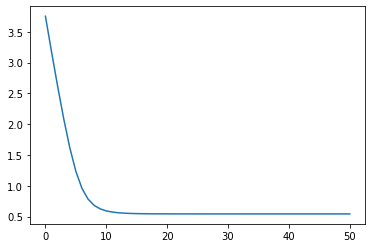

In [187]:
f,ax = plt.subplots()
ax.plot(range(len(log)), log[:,0])